# TECH CHALLENGE 2 - Prophet


TECH CHALLENGE 2

#Estudando e preparando os dados os Dados


In [137]:
!pip install prophet
!pip install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv
import pandas as pd

# Carregar .env
dotenv_path = r"C:\Users\Micro\OneDrive\Área de Trabalho\Tech-Challenge 2\challenge_2\uteis\.env"
load_dotenv(dotenv_path=dotenv_path, override=True)

data_path = os.getenv('DATA_PATH')
nome_arquivo = 'DadosHistoricos_1994_a_2025.csv'
caminho_arquivo = os.path.join(data_path, nome_arquivo)

# Leitura do CSV
df_ibovespa = pd.read_csv(
    caminho_arquivo,
    sep=';',
    encoding='utf-8',
    decimal=',',
    parse_dates=['Data'],
    dayfirst=True
)

print(df_ibovespa.head())
# 1994 - 2025
df_ibovespa_1994 = df_ibovespa.copy()
# 2015 - 2025
df_ibovespa_2015 = df_ibovespa[df_ibovespa['Data'] >= pd.to_datetime('2015-01-01')].copy()  # a partir de 2015

print(f"Tamanho total: {df_ibovespa_1994.shape}")
print(f"Tamanho desde 2015: {df_ibovespa_2015.shape}")


        Data   Último Abertura   Máxima   Mínima   Vol.    Var%
0 2025-07-25  133.524  133.820  134.204  133.285  5,56B  -0,21%
1 2025-07-24  133.808  135.357  135.363  133.648  5,98B  -1,15%
2 2025-07-23  135.368  134.036  135.782  133.676  6,53B   0,99%
3 2025-07-22  134.036  134.180  135.300  133.986  7,05B  -0,10%
4 2025-07-21  134.167  133.382  134.865  133.367  6,73B   0,59%
Tamanho total: (7694, 7)
Tamanho desde 2015: (2620, 7)


In [139]:
df_ibovespa['Data'] = pd.to_datetime(
    df_ibovespa['Data'],
    format='%d.%m.%Y',
    errors='raise'
)

df_ibovespa["Vol."] = df_ibovespa["Vol."].str.replace("M", "e6").str.replace("B", "e9").str.replace("K", "e3").str.replace(",", ".").astype(float)

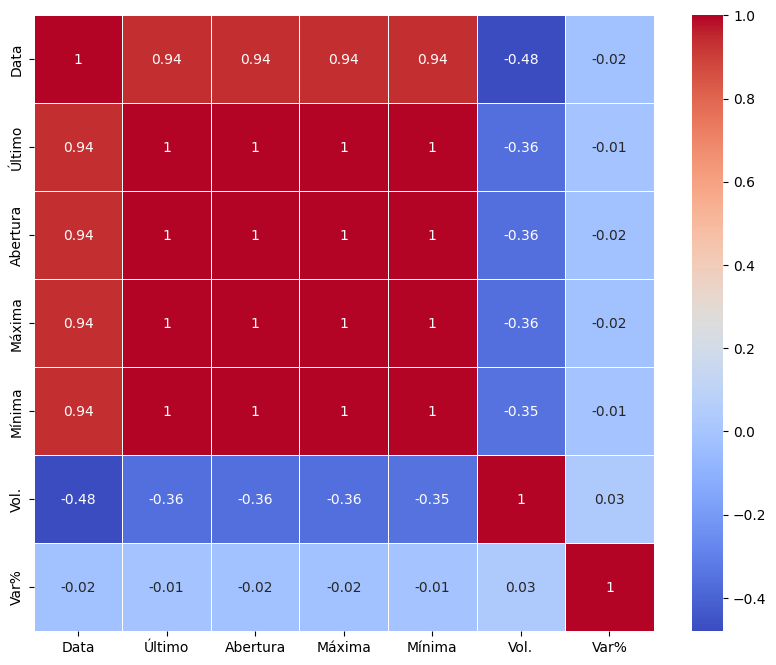

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

df_ibovespa['Var%'] = df_ibovespa['Var%'].astype(str).str.replace('%', '').str.replace(',', '.').astype(float) / 100

correlation_metrics = df_ibovespa.corr().round(2)

fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(correlation_metrics, annot=True,linewidths= .5, ax=ax, cmap="coolwarm")

plt.show()

In [141]:
df_ibovespa.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

#Iniciando o modelo

In [142]:
from sklearn import metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [143]:
df_ibovespa.rename(columns={'Data': 'ds', 'Último': 'y'}, inplace=True)
df_ibovespa.head()

,ds,y,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-07-25,133.524,133.820,134.204,133.285,5.560000e+09,-0.0021
1,2025-07-24,133.808,135.357,135.363,133.648,5.980000e+09,-0.0115
2,2025-07-23,135.368,134.036,135.782,133.676,6.530000e+09,0.0099
3,2025-07-22,134.036,134.180,135.300,133.986,7.050000e+09,-0.0010
4,2025-07-21,134.167,133.382,134.865,133.367,6.730000e+09,0.0059


In [144]:
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7694 entries, 0 to 7693
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        7694 non-null   datetime64[ns]
 1   y         7694 non-null   object        
 2   Abertura  7694 non-null   object        
 3   Máxima    7694 non-null   object        
 4   Mínima    7694 non-null   object        
 5   Vol.      7693 non-null   float64       
 6   Var%      7694 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 420.9+ KB


In [145]:
df_ibovespa.set_index('ds', inplace=True)

df_ibovespa.reset_index(inplace=True)

train_set = df_ibovespa.iloc[:-30]

test_set = df_ibovespa.iloc[-30:]

m = Prophet()

m.fit(df_ibovespa)

02:10:19 - cmdstanpy - INFO - Chain [1] start processing
02:10:21 - cmdstanpy - INFO - Chain [1] done processing


In [146]:
future = m.make_future_dataframe(periods=60, freq='B')

forecast = m.predict(future)

### Apresentando os resultados
Período de 04/07/1994 - Implementação do Plano Real - a 26/07/2025


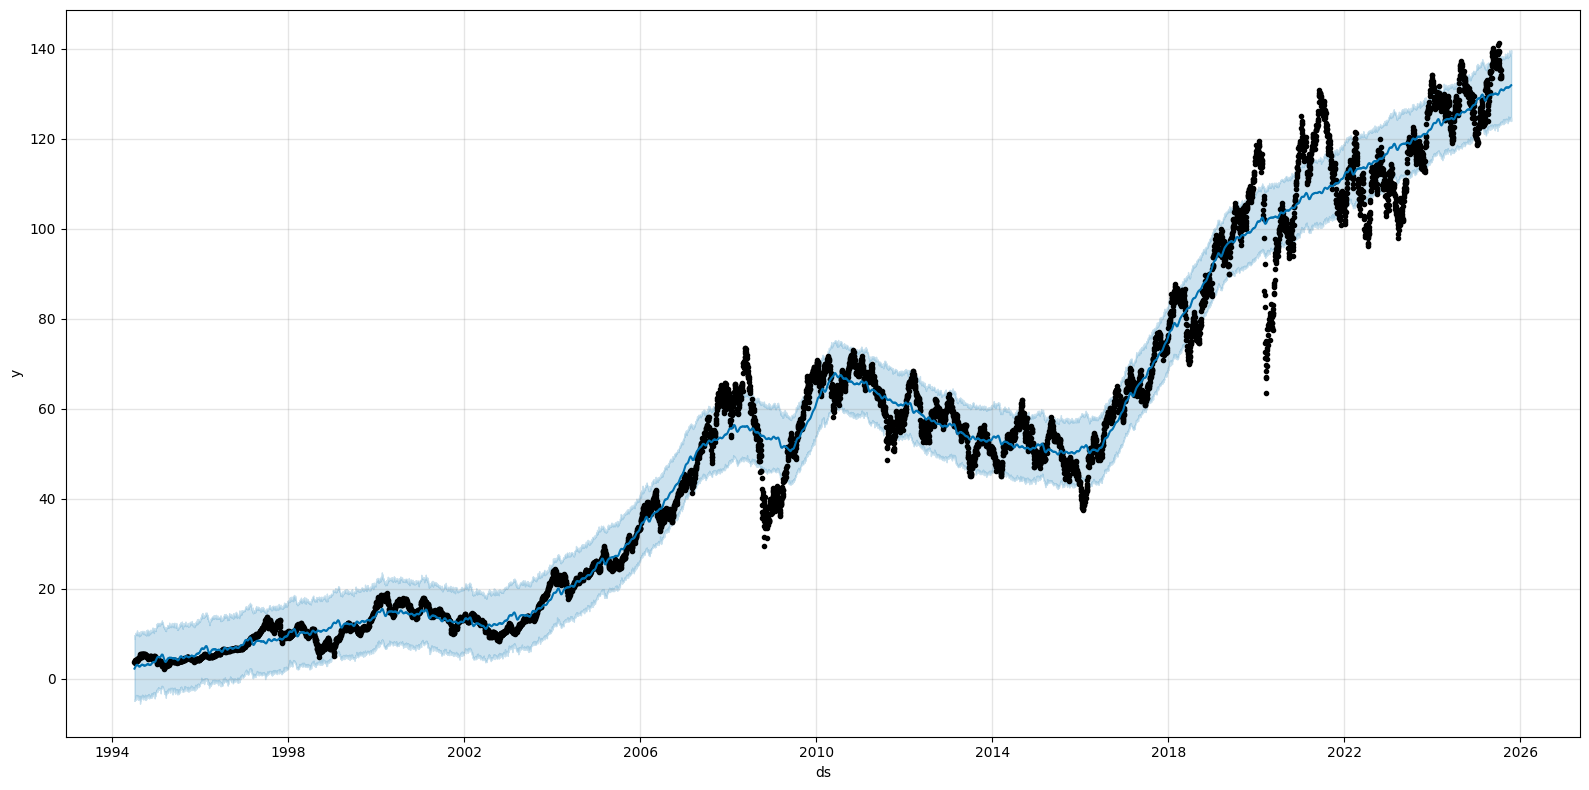

In [147]:
fig = m.plot(forecast, figsize=(16, 8))

In [148]:
import numpy as np
import pandas as pd

df_ibovespa['ds'] = pd.to_datetime(df_ibovespa['ds'], errors='coerce')
forecast['ds'] = pd.to_datetime(forecast['ds'], errors='coerce')

df_ibovespa = df_ibovespa.dropna(subset=['ds'])
forecast = forecast.dropna(subset=['ds'])

data_corte = df_ibovespa['ds'].max()

forecast_future_30 = forecast[
    (forecast['ds'] > data_corte) &
    (forecast['ds'] <= data_corte + pd.Timedelta(days=30))
].copy().reset_index(drop=True)

last_real = float(df_ibovespa.loc[df_ibovespa['ds'] == data_corte, 'y'].values[0])

forecast_future_30['yhat'] = pd.to_numeric(forecast_future_30['yhat'], errors='coerce')

forecast_future_30['prev'] = forecast_future_30['yhat'].shift(1)

forecast_future_30.loc[0, 'prev'] = last_real

forecast_future_30['prev'] = pd.to_numeric(forecast_future_30['prev'], errors='coerce')

forecast_future_30['Tendência'] = np.where(
    forecast_future_30['yhat'] > forecast_future_30['prev'],
    'Subir',
    'Descer'
)

tabela = forecast_future_30[['ds', 'yhat', 'Tendência']]
tabela.columns = ['Data', 'Previsão_IBOVESPA', 'Tendência_Próximo_Dia']

print(tabela.to_string(index=False))



      Data  Previsão_IBOVESPA Tendência_Próximo_Dia
2025-07-28         130.935502                Descer
2025-07-29         130.952151                 Subir
2025-07-30         130.964938                 Subir
2025-07-31         130.947030                Descer
2025-08-01         130.907688                Descer
2025-08-04         130.806287                Descer
2025-08-05         130.811063                 Subir
2025-08-06         130.817283                 Subir
2025-08-07         130.798112                Descer
2025-08-08         130.762693                Descer
2025-08-11         130.701455                Descer
2025-08-12         130.727708                 Subir
2025-08-13         130.758569                 Subir
2025-08-14         130.766586                 Subir
2025-08-15         130.760250                Descer
2025-08-18         130.790827                 Subir
2025-08-19         130.846967                 Subir
2025-08-20         130.906299                 Subir
2025-08-21  

#Testando modelo #


In [149]:
m = Prophet()
m.fit(train_set)

02:10:23 - cmdstanpy - INFO - Chain [1] start processing
02:10:25 - cmdstanpy - INFO - Chain [1] done processing


In [150]:
future_test = test_set[['ds']]  # só as datas
forecast_test = m.predict(future_test)


In [151]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Valores reais
y_true = test_set['y'].values

# Previsões do modelo
y_pred = forecast_test['yhat'].values

# Métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 1.438484401607408
MSE: 2.2865298126688383
RMSE: 1.5121275781721721


In [152]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape:.2f}%")

TypeError: unsupported operand type(s) for -: 'str' and 'float'


📈 Previsões dos próximos 30 dias:

      Data  Previsão_IBOVESPA Tendência_Próximo_Dia  Variação_%
2025-07-21           137.3735                 Subir        2.99
2025-07-22           137.5426                 Subir        0.12
2025-07-23           137.5479                 Subir        0.00
2025-07-24           137.6171                 Subir        0.05
2025-07-25           137.6837                 Subir        0.05
2025-07-28           137.7727                 Subir        0.06
2025-07-29           137.8866                 Subir        0.08
2025-07-30           137.8372                Descer       -0.04
2025-07-31           137.8532                 Subir        0.01
2025-08-01           137.8688                 Subir        0.01
2025-08-04           137.8256                Descer       -0.03
2025-08-05           137.9045                 Subir        0.06
2025-08-06           137.8255                Descer       -0.06
2025-08-07           137.8176                Descer       -0.01
2025

22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_5684\2073661135.py:118: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_5684\2073661135.py:118: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\T-GAMER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\T-GAMER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font

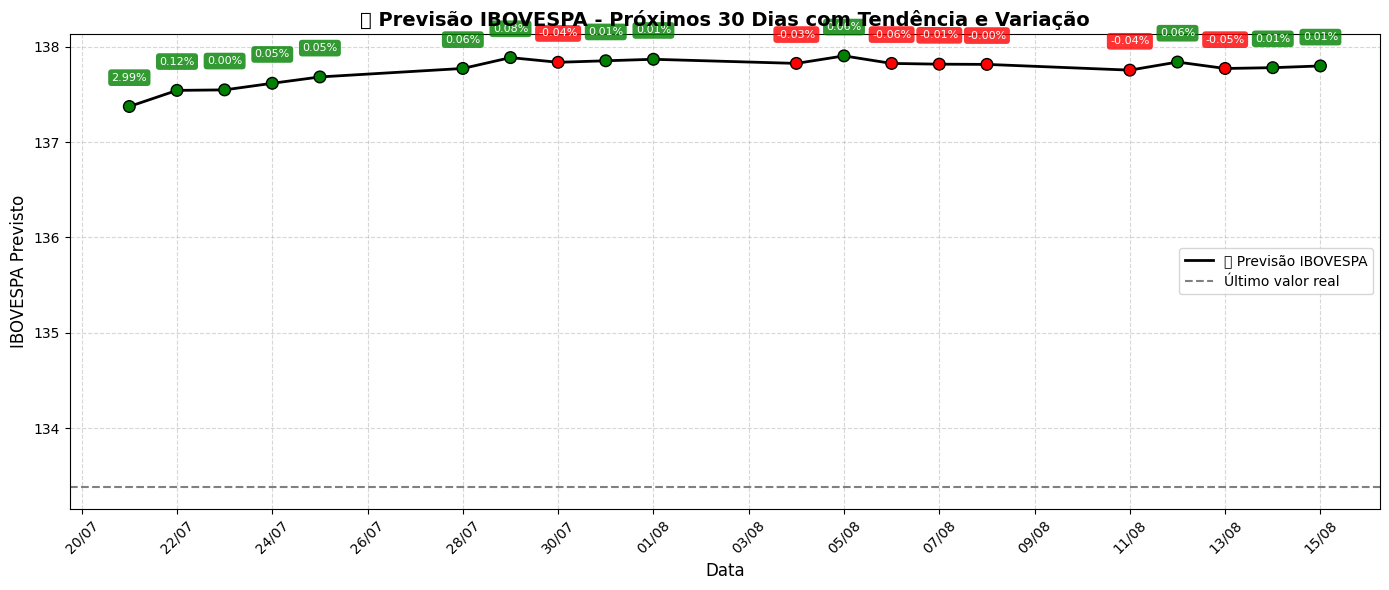

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Tratamento de datas ---
df_ibovespa['ds'] = pd.to_datetime(df_ibovespa['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Último valor real do IBOVESPA
last_real = df_ibovespa.loc[df_ibovespa['ds'] == df_ibovespa['ds'].max(), 'y'].values[0]

# Previsão dos próximos 30 dias
data_corte = df_ibovespa['ds'].max()
forecast_future_30 = forecast[
    (forecast['ds'] > data_corte) &
    (forecast['ds'] <= data_corte + pd.Timedelta(days=30))
].copy().reset_index(drop=True)

# Valor do dia anterior (shift) e variação
forecast_future_30['prev'] = forecast_future_30['yhat'].shift(1)
forecast_future_30.loc[0, 'prev'] = last_real

forecast_future_30['Tendência'] = np.where(
    forecast_future_30['yhat'] > forecast_future_30['prev'],
    'Subir',
    'Descer'
)

forecast_future_30['Variação_%'] = ((forecast_future_30['yhat'] - forecast_future_30['prev']) / forecast_future_30['prev']) * 100

tabela = forecast_future_30[['ds', 'yhat', 'Tendência', 'Variação_%']].copy()
tabela.columns = ['Data', 'Previsão_IBOVESPA', 'Tendência_Próximo_Dia', 'Variação_%']
tabela['Previsão_IBOVESPA'] = tabela['Previsão_IBOVESPA'].round(4)
tabela['Variação_%'] = tabela['Variação_%'].round(2)

print("\n📈 Previsões dos próximos 30 dias:\n")
print(tabela.to_string(index=False))


# --- Avaliação do modelo ---
y_true = test_set['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n🔍 Métricas de desempenho do modelo:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # opcional
m.fit(train_set)

import matplotlib.pyplot as plt

data_limite = df_ibovespa['ds'].max() - pd.Timedelta(days=30)

df_real_3m = df_ibovespa[df_ibovespa['ds'] >= data_limite]
forecast_3m = forecast[forecast['ds'] >= data_limite]

# --- Gráfico da Previsão Futura (Próximos 30 dias) ---
# plt.figure(figsize=(12, 6))
# plt.plot(forecast_future_30['ds'], forecast_future_30['yhat'], label='Previsão - Próximos 30 dias', color='blue', marker='o')
# plt.title('📆 Previsão dos Próximos 30 Dias - IBOVESPA')
# plt.xlabel('Data')
# plt.ylabel('Previsão do IBOVESPA')
# plt.grid(True)
# plt.legend()
# plt.axhline(y=last_real, color='gray', linestyle='--', label='Último valor real')
# plt.tight_layout()
# plt.xticks(rotation=45)
# plt.show()
# Mapa de cores baseado na tendência
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Gráfico
fig, ax = plt.subplots(figsize=(14, 6))

# Linha principal
ax.plot(forecast_future_30['ds'], forecast_future_30['yhat'], color='black', linewidth=2, label='📈 Previsão IBOVESPA')

# Pontos coloridos por tendência
cores = forecast_future_30['Tendência'].map({'Subir': 'green', 'Descer': 'red'})
ax.scatter(forecast_future_30['ds'], forecast_future_30['yhat'], color=cores, s=70, edgecolor='black', zorder=5)

# Último valor real
ax.axhline(y=last_real, color='gray', linestyle='--', linewidth=1.5, label='Último valor real')

# Rótulos de variação com caixinha
for i, row in forecast_future_30.iterrows():
    ax.text(row['ds'], row['yhat'] + 0.25, f"{row['Variação_%']:.2f}%",
            ha='center', va='bottom', fontsize=8, color='white',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=cores[i], edgecolor='none', alpha=0.8))

# Formatação de datas
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Títulos e rótulos
plt.title('📊 Previsão IBOVESPA - Próximos 30 Dias com Tendência e Variação', fontsize=14, weight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('IBOVESPA Previsto', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()